# Кластеризация

## Задание 1

Разбейте множество объектов из набора данных pluton.csv на 3 кластера с помощью k-means. Сравните качество разбиения в зависимости от максимального числа итераций алгоритма и использования стандартизации.

使用k-means将pluton.csv数据集的对象集划分为3个集群。根据算法的最大迭代次数和标准化的使用，比较分区的质量

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


def get_arr_sc_sse(data, arr_iter):
    # KMeans
    arr_sc = []
    arr_sse = []
    for iter in arr_iter:
        estimator = KMeans(n_clusters=3, max_iter=iter, random_state=90102)
        estimator.fit(X=data)
        sc = silhouette_score(X=data, labels=estimator.predict(X=data))
        arr_sc.append(sc)
        arr_sse.append(estimator.inertia_)
    return arr_sc, arr_sse

arr_iter = range(1, 500)
data = pd.read_csv(filepath_or_buffer='./pluton.csv')
arr_sc_scaler_off, arr_sse_scaler_off = get_arr_sc_sse(data, arr_iter)

# 标准化
transfer = StandardScaler()
data = transfer.fit_transform(X=data)
arr_sc_scaler_on, arr_sse_scaler_on = get_arr_sc_sse(data, arr_iter)

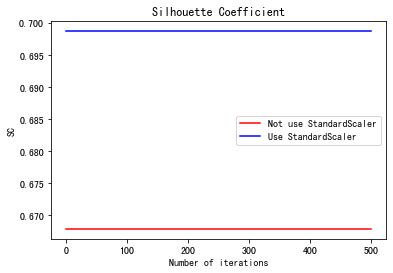

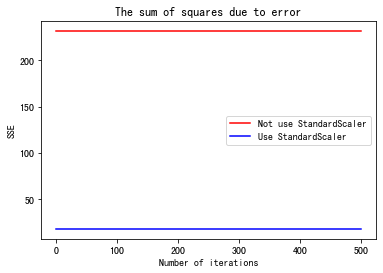

In [44]:
plt.figure()
plt.plot(arr_iter, arr_sc_scaler_off, ms=2, color='r', label='Not use StandardScaler')
plt.plot(arr_iter, arr_sc_scaler_on, ms=2, color='b', label='Use StandardScaler')
plt.legend()
plt.title('Silhouette Coefficient')
plt.xlabel('Number of iterations')
plt.ylabel('SC')
plt.show()

plt.figure()
plt.plot(arr_iter, arr_sse_scaler_off, ms=2, color='r', label='Not use StandardScaler')
plt.plot(arr_iter, arr_sse_scaler_on, ms=2, color='b', label='Use StandardScaler')
plt.legend()
plt.title('The sum of squares due to error')
plt.xlabel('Number of iterations')
plt.ylabel('SSE')
plt.show()

## Задание 2

Разбейте на кластеры множество объектов из наборов данных clustering_1.csv, clustering_2.csv и clustering_3.csv с помощью k-means, DBSCAN и иерархической кластеризации. Определите оптимальное количество кластеров (где это применимо). Какой из методов сработал лучше и почему? 

使用k-means、DBSCAN和分层聚类法将clustering_1.csv、clustering_2.csv和clustering_3.csv数据集中的对象集划分为群组。确定集群的最佳数量（如适用）。哪种方法效果更好，为什么？

### clustering_1.csv

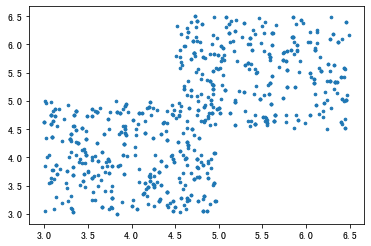

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


data = pd.read_csv(filepath_or_buffer='./clustering_1.csv', sep='\t', names=['X1', 'X2'])
plt.figure()
plt.scatter(data['X1'], data['X2'], s=7)
plt.show()

In [203]:
def plot_csv1(estimator, data, title, save_path='./result/pic.png'):
    predict = estimator.fit_predict(data)
    arr_labels = np.unique(predict)
    res_cluster = pd.concat([data, pd.Series(predict, name='target')], axis=1)
    plt.figure()
    for label in arr_labels:
        plt.scatter(res_cluster[res_cluster['target'] == label]['X1'],
                    res_cluster[res_cluster['target'] == label]['X2'],
                    s=7)
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

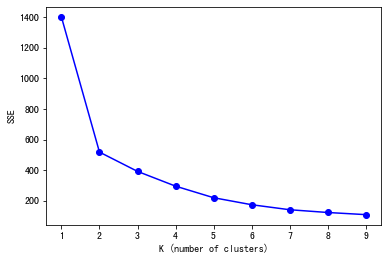

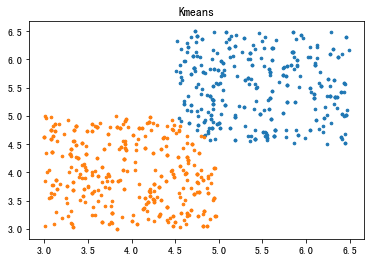

In [165]:
# KMeans
arr_cluster = range(1, 10)
arr_sse = []
for cluster in arr_cluster:
    estimator = KMeans(n_clusters=cluster, random_state=90102)
    estimator.fit(X=data)
    arr_sse.append(estimator.inertia_)

# 使用肘方法确定最佳的 n_clusters 值
plt.figure()
plt.plot(arr_cluster, arr_sse, marker='o', ms=6, color='b')
plt.xlabel('K (number of clusters)')
plt.ylabel('SSE')

# 使用最佳的 n_clusters 值进行模型训练
estimator = KMeans(n_clusters=2, random_state=90102)
plot_csv1(estimator, data, 'Kmeans')

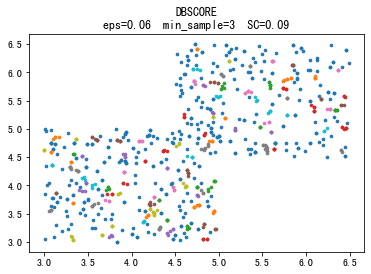

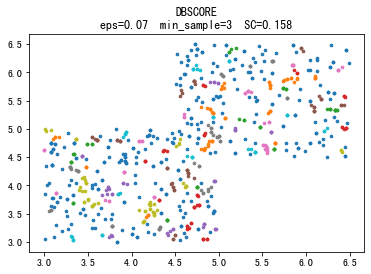

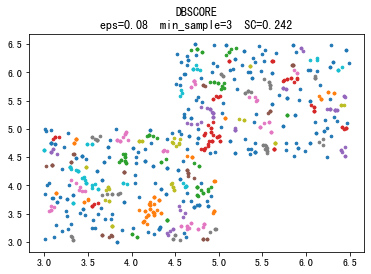

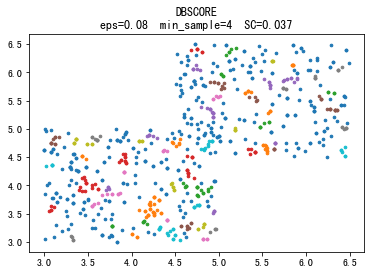

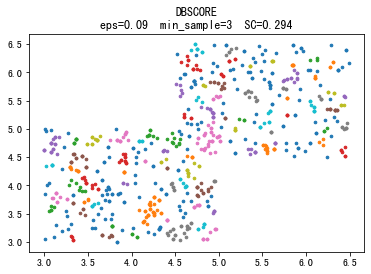

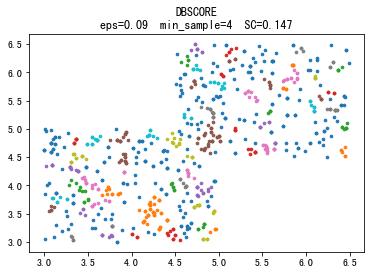

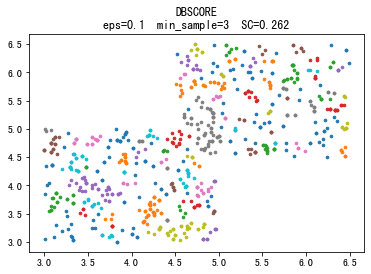

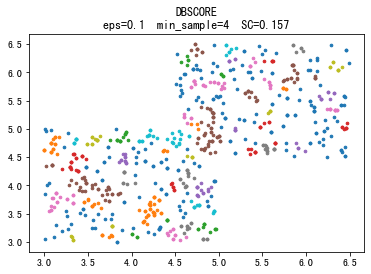

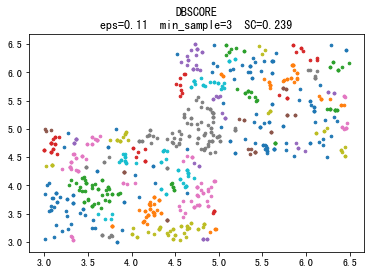

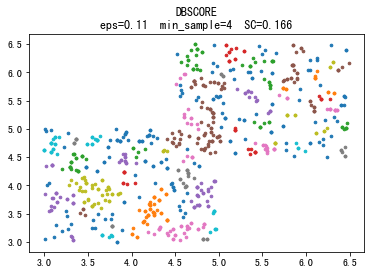

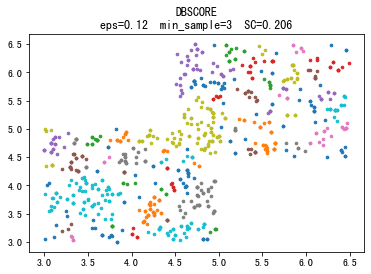

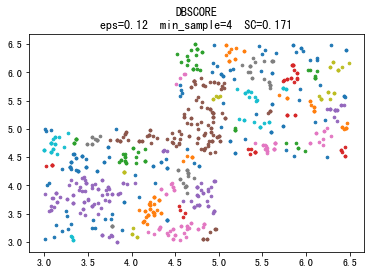

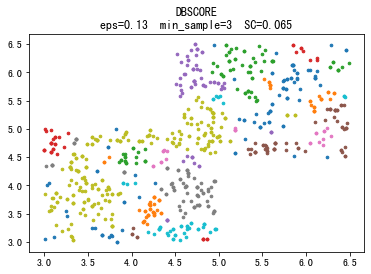

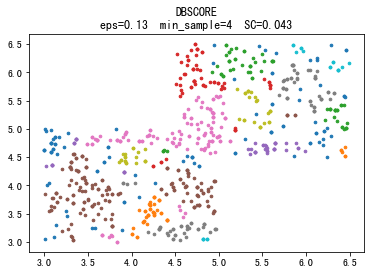

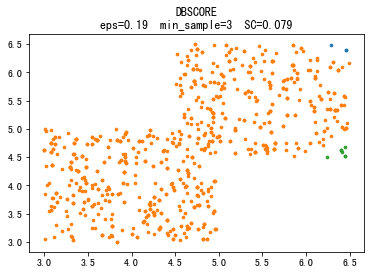

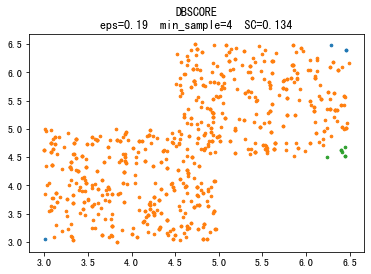

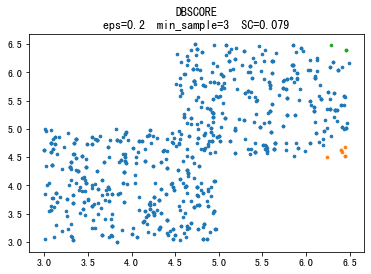

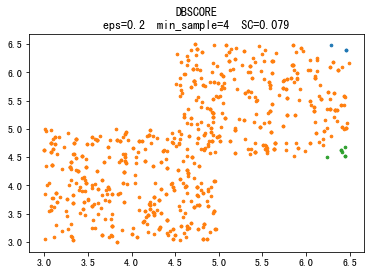

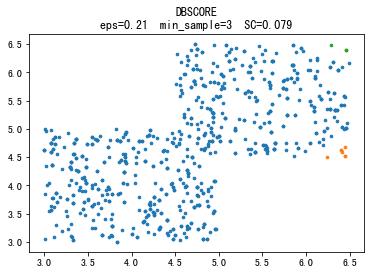

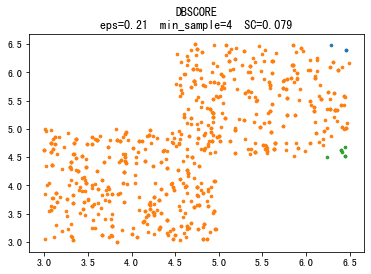

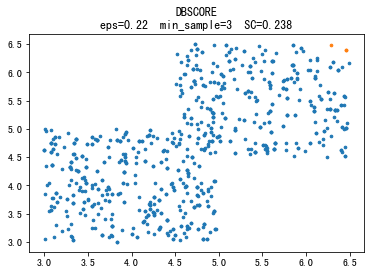

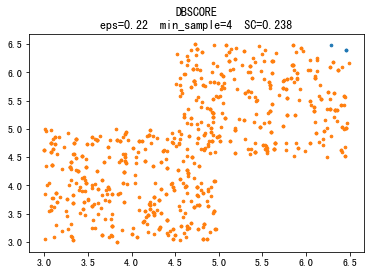

In [204]:
# DBSCAN
arr_eps = np.arange(start=0.01, stop=0.3, step=0.01)
arr_min_sample = range(3, 5)
arr_res_sc_DBSCAN = []

for eps in arr_eps:
    for min_sample in arr_min_sample:
        estimator = DBSCAN(eps=eps, min_samples=min_sample)
        predict = estimator.fit_predict(data)

        # 如果都预测成了同一种就跳过
        if len(np.unique(ar=predict)) == 1:
            continue

        sc = silhouette_score(X=data, labels=predict)
        arr_res_sc_DBSCAN.append([eps, min_sample, sc])
        
        # 仅绘制 SC 大于 0.1 的分类图像
        if sc > 0:
            plot_csv1(estimator=estimator, data=data,
                      title=f'DBSCORE\neps={round(eps, 2)}  min_sample={min_sample}  SC={round(sc, 3)}',
                      save_path=f'./result/DBSCAN_{len(arr_res_sc_DBSCAN)}.png')


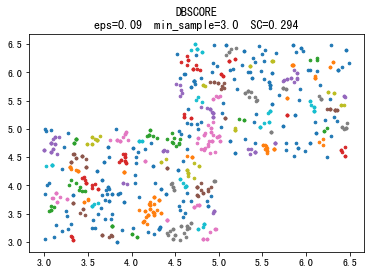

In [198]:
# 根据 SC 分值最高的进行分类结果可视化
arr_res_sc_DBSCAN = pd.DataFrame(arr_res_sc_DBSCAN, columns=['eps', 'min_samples', 'SC'])
best_para = arr_res_sc_DBSCAN[arr_res_sc_DBSCAN['SC'] == arr_res_sc_DBSCAN['SC'].max()]
best_eps = best_para.values[0][0]
best_min_samples = best_para.values[0][1]
best_sc = best_para.values[0][2]
estimator = DBSCAN(eps=best_eps, min_samples=best_min_samples)

plot_csv1(estimator, data, f'DBSCORE\neps={round(best_eps, 2)}  min_sample={best_min_samples}  SC={round(best_sc, 3)}')

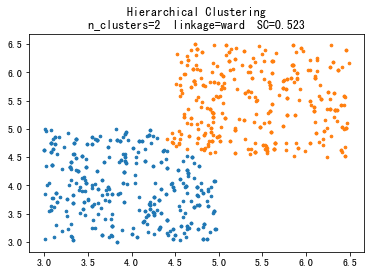

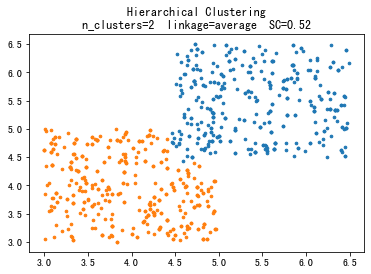

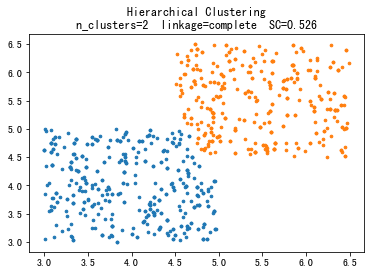

In [207]:
# Hierarchical Clustering

for linkage in ('ward', 'average', 'complete'):
    estimator  = AgglomerativeClustering(n_clusters=2, linkage=linkage)
    predict = estimator.fit_predict(X=data)
    sc = silhouette_score(X=data, labels=predict)
    plot_csv1(estimator, data, f'Hierarchical Clustering\nn_clusters=2  linkage={linkage}  SC={round(sc, 3)}')

### clustering_2.csv

### clustering_3.csv

## Задание 3

Осуществите сжатие цветовой палитры изображения (любого, на ваш выбор). Для этого выделите n кластеров из цветов всех пикселей изображения и зафиксируйте центра этих кластеров. Создайте изображение с цветами из сокращенной палитры (цвета пикселей только из центров выделенных кластеров). Покажите исходное и сжатое изображения.

在一幅图像上进行调色板压缩（你选择的任何一幅）。要做到这一点，从图像中所有像素的颜色中选择n个簇，并固定这些簇的中心。用缩小的调色板中的颜色（仅来自所选群组中心的像素颜色）创建一个图像。显示原始图像和缩小后的图像


## Задание 4

Постройте дендрограмму для набора данных votes.csv (число голосов, поданных за республиканцев на выборах с 1856 по 1976 год). Строки представляют 50 штатов, а столбцы -  годы выборов (31). Проинтерпретируйте полученный результат.

为votes.csv数据集（1856年至1976年的选举中投给共和党人的票数）构建树状图。行代表50个州，列代表选举年（31）。解释获得的结果